In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv','customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv','sellers'),
    ('products.csv','products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv','payments'),
    ('order_items.csv', 'order_items')
 # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'avro1234',
    database = 'e_commerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/AVRODITA/OneDrive/Desktop/SQL/E_commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect( host = 'localhost',
                              user = 'root',
                              password = 'avro1234',
                              database = 'e_commerce')
cur = db.cursor()


# Questions part -1

# 1. List all unique cities where customers are located.


In [2]:
query =  """select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.


In [3]:
query =  """select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are", data[0][0]

('Total orders placed in 2017 are', 45101)

# 3. Find the total sales per category.

In [4]:
query =  """select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [5]:
query =  """select (sum(case when payment_installments >=1 then 1
else 0 end))/count(*)*100 from payments """


cur.execute(query)

data = cur.fetchall()
"The percentage of orders that were paid in installments is",data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# 5. Count the number of customers from each state. 

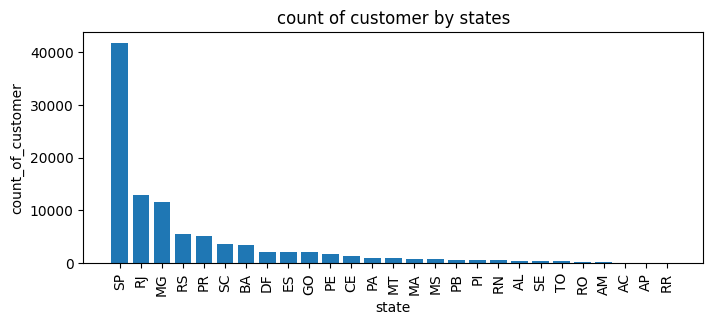

In [6]:
query =  """select customer_state,count(customer_id)
from customers group by customer_state """ 

cur.execute(query)

data = cur.fetchall()
df = pd. DataFrame(data, columns = ["state","customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)


plt.figure(figsize =(8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("state")
plt.ylabel("count_of_customer")
plt.title("count of customer by states")

plt.show()


# Question part- 2

# 1. Calculate the number of orders per month in 2018.

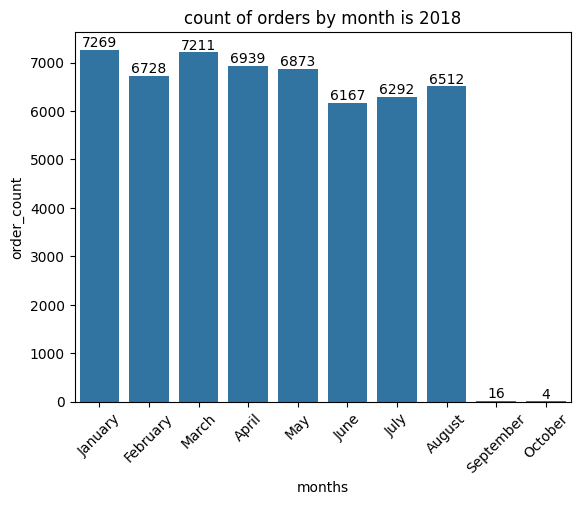

In [7]:
query =  """select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months","order_count"])
o = ["January","February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"], y =df["order_count"], data = df, order = o)
plt.xticks(rotation = 45)
ax.bar_label (ax.containers[0])
plt.title("count of orders by month is 2018")

plt.show()

# 2. Find the average number of products per order, grouped by customer city.


In [8]:
query =  """ with count_per_order as
 (select orders.order_id,orders.customer_id, count(order_items.order_id) as oc
 from orders join order_items on orders.order_id = order_items.order_id
 group by orders.order_id,orders.customer_id)
 
 select customers.customer_city,round(avg(count_per_order.oc),2) average_orders 
 from customers join count_per_order on customers.customer_id= count_per_order.customer_id
 group by customers.customer_city order by average_orders desc; """ 

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns=["customer_city","average_product_per_order"])
df.head(10)


,customer_city,average_product_per_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 3. Identify the correlation between product price and the number of times a product has been purchased.

In [16]:
query =  """ SELECT 
    products.product_category,
    COUNT(order_items.product_id),
    ROUND(AVG(order_items.price), 2)
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category; """ 

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data,columns=["category","order_count","price"])

arr1=df["order_count"]
arr2=df["price"]

a = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchase is",a[0],[-1])

The correlation between product price and the number of times a product has been purchase is [ 1.         -0.10631514] [-1]


# 4. Calculate the total revenue generated by each seller, and rank them by revenue.

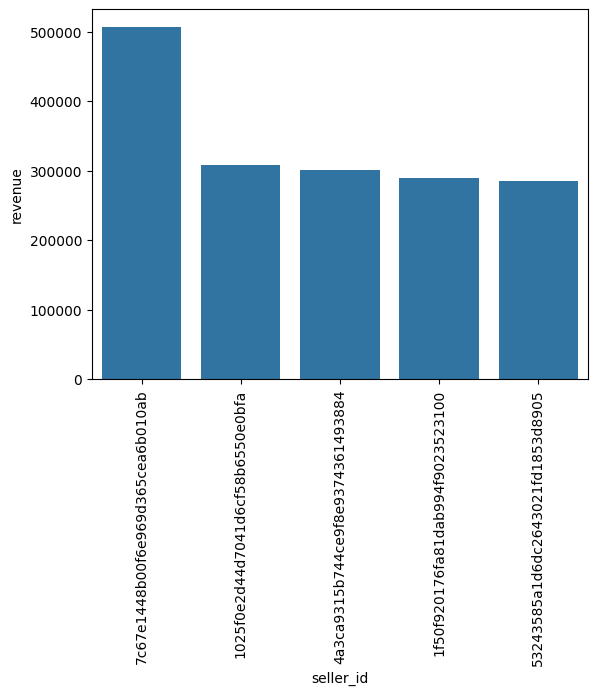

In [23]:
query =  """ select *, dense_rank() over (order by revenue desc) as rn from

(select order_items.seller_id, sum(payments.payment_value) revenue from order_items
 join payments on order_items.order_id=payments.order_id
 group by order_items.seller_id) as a """ 

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df=df.head(5)

sns.barplot(x="seller_id", y="revenue",data=df)
plt.xticks(rotation=90)
plt.show()

# 5. Calculate the percentage of total revenue contributed by each product category.

In [22]:
query =  """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc; """ 

cur.execute(query)
df=pd.DataFrame(data, columns=["category","percentage_distribution"])
df.head(10)

,category,percentage_distribution
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Questions part - 3

# 1. Calculate the moving average of order values for each customer over their order history.

In [5]:
query =  """ select customer_id, order_purchase_timestamp,payment,avg(payment) 
over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) moving_avg 
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment from payments
join orders on payments.order_id=orders.order_id) as a; """ 

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data,columns=["customer_id","order_purchase_timestamp","payment","moving_avg"])
df

,customer_id,order_purchase_timestamp,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 2. Calculate the cumulative sales per month for each year.

In [27]:
query =  """ 
select years,months,payment,avg(payment) over(order by years,months) cumulative_sales from
(SELECT 
    YEAR(orders.order_purchase_timestamp) AS years,
    MONTH(orders.order_purchase_timestamp) AS months,
    ROUND(SUM(payments.payment_value),2) AS payment
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id
GROUP BY years , months
ORDER BY years , months) as a; """ 

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data,columns=["years","months","payment","cumulative_sales"])
df

,years,months,payment,cumulative_sales
0,2016,9,252.24,252.240000
1,2016,10,59090.48,29671.360000
2,2016,12,19.62,19787.446667
3,2017,1,138488.04,49462.595000
4,2017,2,291908.01,97951.678000
5,2017,3,449863.60,156603.665000
6,2017,4,417788.03,193915.717143
7,2017,5,592918.82,243791.105000
8,2017,6,511276.38,273511.691111
9,2017,7,592382.92,305398.814000


# 3. Calculate the year-over-year growth rate of total sales.

In [37]:
query =  """with a as (SELECT 
    YEAR(orders.order_purchase_timestamp) AS years,
    ROUND(SUM(payments.payment_value),2) AS payment
FROM
    orders
        JOIN
    payments ON orders.order_id = payments.order_id
GROUP BY years
ORDER BY years)
select years,((payment-lag(payment,1) over(order by years))/ lag(payment,1) over(order by years))*100 from a""" 

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns=["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [8]:
query =  """ with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders 
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders 
on orders.customer_id=a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id=b.customer_id;
 """ 

cur.execute(query)

data = cur.fetchall()
data

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year.

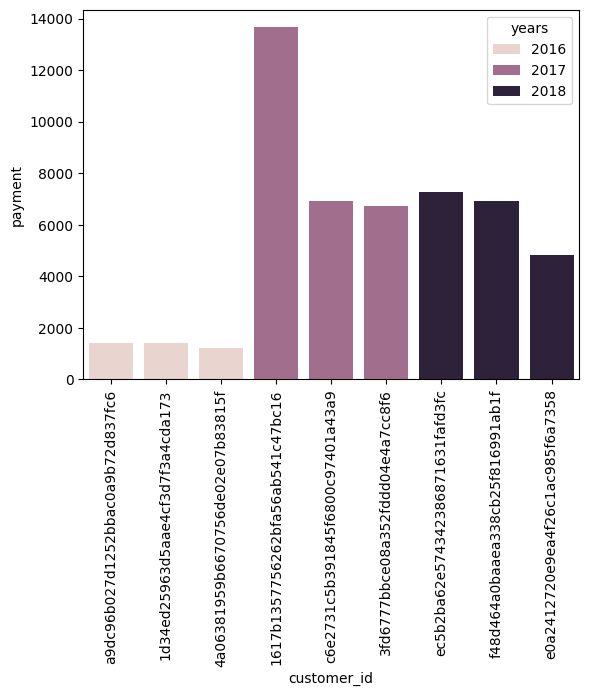

In [7]:
query =  """ select years,customer_id,payment,d_rank
 from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank 
from orders join payments on payments.order_id=orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank<=3; """ 

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data,columns=["years","customer_id","payment","d_rank"])
sns.barplot(x="customer_id",y="payment", hue="years", data=df)
plt.xticks(rotation=90)
plt.show()                                              